# EECS 504: Foundation of Computer Vision

*Final Project*:  **Instance Style Transfer**

*Sub Project*:  **Depth-aware and Laplacian-steered Instance Style Transfer**

*Team members*:  **Lingjun Zhao, Junkai Zhang**

Note: This ipynb file is set to realize the Depth-aware and Laplacian-steered Style Transfer part. To complete the whole project, we have to obtain and upload the generated semantic segmentation results of the images from the Semantic Segmentation part which is in another ipynb titled "FCN".

# Starting

Import the modules we need.

In [ ]:
!pip install torchsummary
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from matplotlib import image
import glob as glob
from PIL import Image
import cv2

import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print("Using the GPU!")
else:
  print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116
Using the GPU!


In [ ]:
# MiDaS depends on timm. Used for image depth estimation
!pip install timm

## Step 0: Downloading the dataset and backbone network.
For this problem, we will use five images as our artistic style, and the Coco validation set as our content image.

A pretrained VGG 19 will be applied to extract features.

In [ ]:
if os.path.isdir('styles') and os.path.isdir('contents'):
  print('Style images exist')
else:
  print('Downloading images')
  # Download style images
  !wget https://eecs.umich.edu/courses/eecs442-ahowens/fa22/data/style_images.zip
  !unzip style_images.zip && rm style_images.zip

  # Download content images
  !wget http://images.cocodataset.org/zips/val2017.zip
  !unzip -q val2017.zip && rm val2017.zip
  !mkdir contents
  !mv val2017/* ./contents/

Load the SBD Dataset which is the augmented VOC2012 Dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/EECS504/project/VOC2012Aug.zip' -d '/content/VOC2012Aug'

In [ ]:
# Download the VGG19 model
cnn = torchvision.models.vgg19(pretrained=True).features
cnn = cnn.to(device).eval()

# Freeze the parameters as there's no need to train the net. Ignore the warnings.
for param in cnn.parameters():
    param.requires_grad = False

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

## STEP 1: Create the image loader and some utility funtions
Provide the dataloader for images and a function to get the list of feature maps from a forward pass in the network.

torch.Size([1, 3, 224, 224])


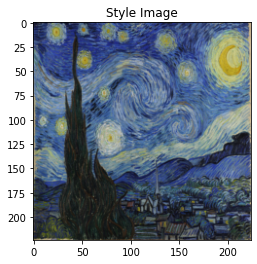

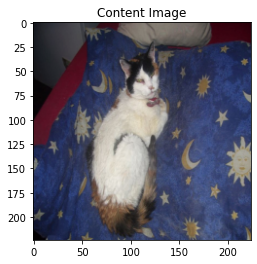

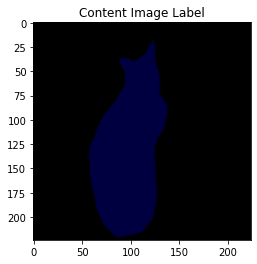

In [ ]:
# Dataloader
imsize = 224

# SQUEEZENET_MEAN = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float)
# SQUEEZENET_STD = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float)
VGG19_MEAN = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float)
VGG19_STD = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float)


def image_loader(image_name, imsize):
    image = Image.open(image_name)
    transform = transforms.Compose([
                transforms.Resize((imsize, imsize)),
                transforms.ToTensor(),
                transforms.Normalize(mean=VGG19_MEAN.tolist(), std=VGG19_STD.tolist()),
                transforms.Lambda(lambda x: x[None]),
                ])
    image = transform(image)
    return image.to(device, torch.float)

# visualizing the content and style images

style_img = image_loader("styles/starry_night.jpg", imsize)
# print(style_img.shape) # tensor (1, 3, 224, 224)
content_img = image_loader("/content/VOC2012Aug/img/2008_003420.jpg", imsize)
# print(content_img.shape) # tensor (1, 3, 224, 224)
content_img_label = image_loader("/content/VOC2012Aug/cls_aug_png/2008_003420.png", imsize)
print(content_img_label.shape)

def deprocess(img):
    transform = transforms.Compose(
        [
            transforms.Lambda(lambda x: x[0]),
            transforms.Normalize(mean=[0, 0, 0], std=(1.0 / VGG19_STD).tolist()),
            transforms.Normalize(mean=(-VGG19_MEAN).tolist(), std=[1, 1, 1]),
            transforms.Lambda(lambda x: x),
            transforms.ToPILImage(),
        ]
    )
    return transform(img)

plt.ion()

def imshow(im_tensor, title=None):
    image = im_tensor.cpu().clone()    
    image = deprocess(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

    return image


plt.figure()
Style_Image = imshow(style_img, title='Style Image')

plt.figure()
Content_Image = imshow(content_img, title='Content Image')

plt.figure()
Content_Image_Label = imshow(content_img_label, title='Content Image Label')

Use the MiDaS network implemented from Pytorch to estimate the depth of a certain image

In [ ]:
# Load a model
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
#model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

# Load transforms to resize and normalize the image for large or small model
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
  depth_transform = midas_transforms.dpt_transform
else:
  depth_transform = midas_transforms.small_transform

Use MiDaS to test on an image

(375, 500, 3)
torch.Size([1, 3, 384, 512])
torch.Size([375, 500])
(375, 500)


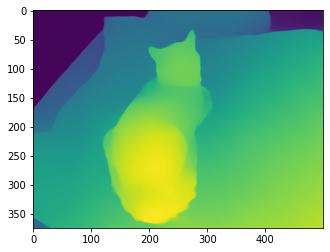

In [ ]:
# Load image and apply transforms
filename = "/content/VOC2012Aug/img/2008_003420.jpg"
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape) # (height, width, channel) -- numpy array (427, 640, 3)
input_batch = depth_transform(img).to(device)
print(input_batch.shape) # (batch, channel, height, width) -- tensor (1, 3, 384, 576)

# Predict and resize to original resolution
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

print(prediction.shape) # (height, width) -- tensor (427, 640)
output = prediction.cpu().numpy()
print(output.shape) # (height, width) -- numpy array (427, 640)
# Show result
plt.imshow(output)
# plt.show()

Some utility functions

In [ ]:
def get_feature_maps(x, cnn):
    """
    Get the list of feature maps in a forward pass.
    
    Inputs:
    - x: A batch of images with shape (B, C, H, W)
    - cnn: A PyTorch model that we will use to extract features.
    
    Returns:
    - features: A list of features for the input images x extracted using the cnn model.
      features[i] is a Tensor of shape (B, C_i, H_i, W_i).
    """
    feats = []
    in_feat = x
    for layer in cnn._modules.values():
        out_feat = layer(in_feat)
        feats.append(out_feat)
        in_feat = out_feat
    return feats

## Step 2: Implementing content loss
Firstly, we will implement the content loss. This loss encourages the generated image to match the scene structure of the content image. We will implement this loss as the squared $\ell_2$ distance between two convolutional feature maps. Given a feature map of input image $F^x$ and the feature map of content image $F^{c}$, both of shape $(C, H, W)$, the content loss is calculated as follows:

\begin{equation}
\mathcal{L}_c = \sum_{c,i,j}(F^{c}_{c, i, j} - F^{x}_{c, i, j}) ^ 2. 
\end{equation}

In [ ]:
def content_loss(f_x, f_con):
    """
    Compute the content loss.
    
    Inputs:
    - f_x: features of the input image with tensor size (1, C, H, W).
    - f_con: features of the content image with tensor size (1, C, H, W).
    Returns:
    - lc: the content loss
    """
    f_temp = f_x - f_con
    lc = torch.sum(f_temp**2) 

    return lc

## Step 3: Implementing depth loss
Then we will implement the depth loss. The depth loss function is used to measure the depth differences between the transformed image and the content target image. In order to preserve maximum depth information and potential structural features, we take the outputs of the depth estimation network and compute the distances as the depth loss. 

We choose **MiDaS** as the depth estimation network. The dpeth loss is the (squared, normalized) Euclidean distance between feature representations:
\begin{equation}
    \mathcal{L}_d = \sum_{i,j}(D^{c}_{i, j} - D^{x}_{i, j}) ^ 2. 
\end{equation}


In [ ]:
def depth_loss(content_img, stylised_img):
    """
    Compute the depth loss.
    
    Inputs:
    - content_img: the content image with tensor size (1, C, H, W).
    - stylised_img: the stylised image with tensor size (1, C, H, W).
    Returns:
    - ld: the depth loss
    """
    # print(content_img.shape)
    # print(stylised_img.shape)
    
    # Firstly perform depth estimation on both content image and stylised image
    # For content image
    content_img_batch = depth_transform(content_img).to(device)
    # print(content_img_batch.shape)
    with torch.no_grad():
        content_img_prediction = midas(content_img_batch)

        content_img_prediction = torch.nn.functional.interpolate(
            content_img_prediction.unsqueeze(1),
            size=content_img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    content_depth_output = content_img_prediction
    # content_depth_output = content_img_prediction.cpu().numpy()
    
    # For stylised image
    stylised_img_batch = depth_transform(stylised_img).to(device)
    # print(stylised_img_batch.shape)
    with torch.no_grad():
        stylised_img_prediction = midas(stylised_img_batch)

        stylised_img_prediction = torch.nn.functional.interpolate(
            stylised_img_prediction.unsqueeze(1),
            size=stylised_img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()
    stylised_depth_output = stylised_img_prediction
    # stylised_depth_output = stylised_img_prediction.cpu().numpy()

    # Compute the Euclidean distance
    D_diff = content_depth_output - stylised_depth_output
    ld = torch.sum(D_diff**2)
    # Normalize the depth image
    ld /= D_diff.shape[0] * D_diff.shape[1]

    return ld

## Step 4: Implementing style loss
Next, we will implement the style loss. This loss encourages the texture of the resulting image to match the input style image. We compute a weighted, squared $\ell_2$ distance between Gram matrices for several layers of the network.

The first step is to calculate the Gram matrix. Given a feature map $F$ of size $(C, H, W)$, the Gram matrix $G \in \mathbb{R}^{C \times C}$ computes the sum of products between channels. The entries $k, l$ of the matrix are computed as:
\begin{equation}
G_{k,l} = \sum_{i,j} F_{k,i,j} F_{l,i,j}.
\end{equation}

The second step is to compare the generated image's Gram matrix with that of the input style image. Define the Gram matrix of input image feature map and style image feature map of at the $l^{th}$ layer as $G^{x,l}$ and $G^{s, l}$, and the weight of the layer as $w^l$. Style loss at the $l^{th}$ layer is
\begin{equation}
L_s^l = w^l \sum_{i,j} (G^{x,l}_{i,j} - G^{s, l}_{i,j})^2,
\end{equation}
where $w^l$ is the weight of layer $l$. The total style loss is a sum over all style layers:
\begin{equation}
    \mathcal{L}_s = \sum_l L_s^l.
\end{equation}

In [ ]:
def gram_matrix(feat, normalize = True):
    """
    Compute the gram matrix.
    
    Inputs:
    - feat: a feature tensor of shape (1, C, H, W).
    - normalize: if normalize is true, divide the gram matrix by C*H*W:
    Returns
    - gram: the tram matrix
    """
    feat = feat.resize(feat.shape[1], feat.shape[2], feat.shape[3])

    # Use the einsum method to compute vector dot product in high dimension
    gram = torch.einsum("kij,lij->kl", feat, feat)

    # Normalize the gram matrix
    gram = gram/(feat.shape[0]*feat.shape[1]*feat.shape[2])

    return gram

In [ ]:
# Test your gram matrix, you should be expecting a difference smaller than 0.001
t1 = torch.arange(8).reshape(1,2,2,2)
result = torch.tensor([[[ 1.7500,  4.7500],[ 4.7500, 15.7500]]])
print(((gram_matrix(t1) - result)**2).sum().item())

0.0


/usr/local/lib/python3.8/dist-packages/torch/_tensor.py:760: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [ ]:
def style_loss(feats, style_layers, style_targets, style_weights):
    """
    Computes the style loss at a set of layers.
    
    Inputs:
    - feats: list of the features at every layer of the current image, as produced by
      the extract_features function. The list will contain the features of all layers 
      instead of the layers for calcculating style loss
    - style_layers: List of layer indices into feats giving the layers to include in the
      style loss.
    - style_targets: List of the same length as style_layers, where style_targets[i] is
      a PyTorch Tensor giving the Gram matrix of the source style image computed at
      layer style_layers[i].
    - style_weights: List of the same length as style_layers, where style_weights[i]
      is a scalar giving the weight for the style loss at layer style_layers[i].
      
    Returns:
    - loss: A PyTorch Tensor holding a scalar giving the style loss.
    """
    loss = 0.0

    for i in range(len(style_layers)):
      # Compute the Gram matrix of the input feature map from the specified layer
      input_feature_img = feats[style_layers[i]]
      input_gram = gram_matrix(input_feature_img)

      # Compute the difference between the two Gram matrices
      diff = input_gram - style_targets[i]

      # Compute the loss
      loss += style_weights[i] * torch.sum(diff**2)

    return loss

## Step 5: Implementing Laplacian loss
At last, we will implementa Laplacian loss into neural style transfer, to steer the stylised image towards having a similar Laplacian to that of the content image. The Laplacian loss is defined as the mean-squared distance between the two Laplacians.

The Laplacian loss is computed by a small two-layer fixed CNN which includes an average pooling layer and a perspecified convolutional layer. The former layer smoothes the input image which can make the Laplacian loss better reflect its true detail strcutures. The latter layer combines a Laplacian operator to detect the edges of the content image.

In addition, we compute the Laplacian of an image on RGB channels, which means the Laplacian value consists of the three Laplacians:
\begin{equation}
D(x) = D(x^R) + D(x^G) + D(x^B).
\end{equation}
Finally, given the content image and the stylised image, we can compute the Laplacian loss to measure the difference between their Laplacians:
\begin{equation}
L_{Lap} = \sum_{i,j} (D(x_{c}) - D(x))_{i,j}^2.
\end{equation}

In [ ]:
"""
Define a 2-layer neural network to process the content image and the stylised image
An average pooling layer and a Laplacian convolutional layer
"""
class LaplacianNet(nn.Module):
  def __init__(self):
    super(LaplacianNet, self).__init__()
    """
    The LaplacianNet consists of an average pooling layer and a Laplacian conv layer.
    """
    self.avgpooling = nn.AvgPool2d(kernel_size = 3, stride = 1, padding = 1)
    self.laplacian = nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = (3, 3), stride = 1, padding = 1)
    self.laplacian.weight.data = torch.tensor([[[[0, -1, 0],
                          [-1, 4, -1],
                          [0, -1, 0]]]]).float().to(device) # Attention: weight should be float() !!!
  def forward(self, image):
    """
    Args:
    image: torch tensor, shape of (1, C, H, W) ---- RGB three channels input
    # image: torch tensor, shape of (1, 1, H, W) ---- RGB one channels input
    return:
    Laplacian_value: float, sum of the values of the three RGB Laplacians of the image
    """
    # Perform average pooling
    image_pooling = self.avgpooling(image).to(device)
    # Perform RGB Laplacian
    Channels = image.shape[1]
    image_laplacian = torch.zeros((1, 1, image_pooling.shape[2], image_pooling.shape[3])).to(device)

    # RGB three channels
    for i in range(Channels):
      image_laplacian_RGB = self.laplacian(image_pooling[:,i:i+1,:,:])
      image_laplacian += image_laplacian_RGB
    # print("before resize image_laplacian.shape: ", image_laplacian.shape)
    image_laplacian = image_laplacian.resize(image_laplacian.shape[2], image_laplacian.shape[3]).to(device)
    # print("after resize image_laplacian.shape: ", image_laplacian.shape)

    # RGB one channel
    # image_laplacian = self.laplacian(image_pooling)

    return image_laplacian

In [ ]:
# Intialize a LaplacianNet
LaplacianNetwork = LaplacianNet().to(device)
def laplacian_loss(content_img, stylised_img):
    """
    Compute the laplacian loss.
    
    Inputs:
    - content_img: the content image with tensor size (1, C, H, W).
    - stylised_img: the stylised image with tensor size (1, C, H, W).
    Returns:
    - llap: the laplacian loss
    """
    
    # Compute the Laplacian summation of content img and stylised img through the LaplacianNet
    Laplacian_content = LaplacianNetwork(content_img)
    Laplacian_stylised = LaplacianNetwork(stylised_img)

    # Compute the Laplacian loss
    llap = 0.0
    Laplacian_diff = Laplacian_content - Laplacian_stylised
    llap = torch.sum(Laplacian_diff**2)

    return llap

## Step 5: Network Training
Test out the style transfer!

In [ ]:
def style_transfer(content_image, style_image, image_size, style_size, content_layer, content_weight, depth_weight,
                   style_layers, style_weights, laplacian_weight, init_random = False):
    """
    Run style transfer!
    
    Inputs:
    - content_image: filename of content image
    - style_image: filename of style image
    - image_size: size of smallest image dimension (used for content loss and generated image)
    - style_size: size of smallest style image dimension
    - content_layer: layer to use for content loss
    - content_weight: weighting on content loss
    - depth_weight: weighting on depth loss
    - style_layers: list of layers to use for style loss
    - style_weights: list of weights to use for each layer in style_layers
    - laplacian_weight: weighting on Laplacian loss
    - init_random: initialize the starting image to uniform random noise
    """
    
    # Extract features for the content image
    content_img = image_loader(content_image, image_size)
    # print("content_img.shape: ", content_img.shape) # [1, 3, 192, 287]
    feats = get_feature_maps(content_img, cnn)
    content_target = feats[content_layer].clone()

    # Extract features for the style image
    style_img = image_loader(style_image, style_size)
    # print("style_img.shape: ", style_img.shape) # [1, 3, 512, 770]
    feats = get_feature_maps(style_img, cnn)
    style_targets = []

    for idx in style_layers:
        style_targets.append(gram_matrix(feats[idx].clone()))

    # Initialize output image to content image or nois
    if init_random:
        img = torch.Tensor(content_img.size()).uniform_(0, 1).to(device)
    else:
        img = content_img.clone().to(device)

    # We do want the gradient computed on our image!
    img.requires_grad_()
    
    # Set up optimization hyperparameters
    initial_lr = 1
    decayed_lr = 0.1
    decay_lr_at = 180

    # Note that we are optimizing the pixel values of the image by passing
    # in the img Torch tensor, whose requires_grad flag is set to True
    optimizer = torch.optim.Adam([img], lr=initial_lr)
    
    # Show the style image
    plt.figure()
    imshow(style_img, title='Style Image')

    # Show the content image
    plt.figure()
    imshow(content_img, title='Content Image')

    # Show the depth image
    depth_img = cv2.imread(content_image)
    depth_img = cv2.cvtColor(depth_img, cv2.COLOR_BGR2RGB) # depth_img is a numpy array of the original content image

    depth_input_batch = depth_transform(depth_img).to(device)

    # Predict and resize to original resolution
    with torch.no_grad():
        depth_prediction = midas(depth_input_batch)

        depth_prediction = torch.nn.functional.interpolate(
            depth_prediction.unsqueeze(1),
            size=depth_img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_output = depth_prediction.cpu().numpy()
    # Show result
    plt.imshow(depth_output)

    # For depth loss computation
    content_img_depth = content_img.cpu().numpy()
    content_img_depth = content_img_depth.reshape(content_img_depth.shape[2], content_img_depth.shape[3], content_img_depth.shape[1])
    # print("content_img_depth.shape: ", content_img_depth.shape)
    img_depth = img.cpu().detach().numpy()
    img_depth = img_depth.reshape(img_depth.shape[2], img_depth.shape[3], img_depth.shape[1])
    # print("img_dpeth.shape: ", img_depth.shape)

    for t in range(200):
        if t < 190:
            img.data.clamp_(-1.5, 1.5)
        optimizer.zero_grad()

        feats = get_feature_maps(img, cnn)
        
        # Compute loss
        # content loss
        c_loss = content_loss(feats[content_layer], content_target) * content_weight

        # style loss
        s_loss = style_loss(feats, style_layers, style_targets, style_weights)

        # depth loss
        # compute the img_depth
        img_depth = img.cpu().detach().numpy()
        img_depth = img_depth.reshape(img_depth.shape[2], img_depth.shape[3], img_depth.shape[1])
        d_loss = depth_loss(content_img_depth, img_depth) * depth_weight

        # Laplacian loss
        l_loss = laplacian_loss(content_img, img) * laplacian_weight    

        # summation of all the loss
        loss = c_loss + s_loss + d_loss + l_loss
        # loss = c_loss + s_loss + l_loss
        
        loss.backward()

        # Perform gradient descents on our image values
        if t == decay_lr_at:
            optimizer = torch.optim.Adam([img], lr=decayed_lr)
        optimizer.step()

        if t % 100 == 0:
            print('Iteration {}'.format(t))
            plt.figure()
            imshow(img, title='Transferred Image')
            plt.show()
    print('Iteration {}'.format(t))
    plt.figure()
    imshow(img, title='Final transferred Image')

    return img

Test Depth-aware Neural Style Transfer

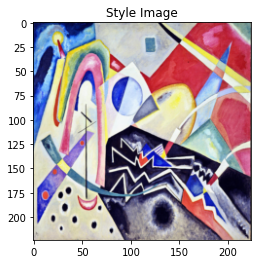

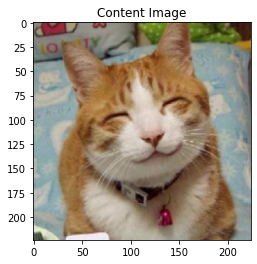

Iteration 0


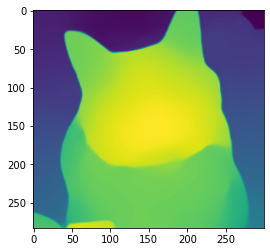

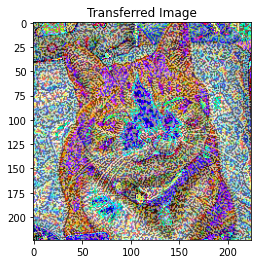

Iteration 100


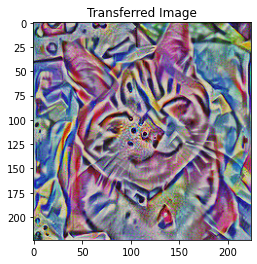

Iteration 199


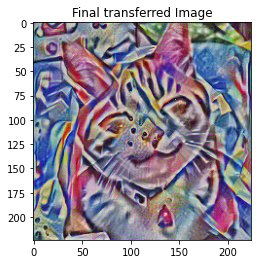

In [ ]:
params1 = {
    # VGG19 params:
    'content_image':'/content/content_image/2008_006599.jpg', # Change the directory to the content image you want!!
    'style_image':'/content/style_image/white zig zags.jpg', # Change the directory to the style image you want!!
    'image_size':224,
    'style_size':224,
    'content_layer':20, # conv4-1
    # 'content_layer':23, # relu4-2
    'content_weight':1,
    'depth_weight':1e4, # finetune
    # 'style_layers':[2, 7, 12, 21, 30], # relu1-1, relu2-1, relu3-1, relu4-1, relu5-1
    'style_layers':[1, 6, 11, 20, 29], # con 1-1, conv2-1, conv3-1, conv4-1, conv5-1
    'style_weights':[1e8, 0.8e7, 0.5e6, 0.3e6, 0.1e6],
    # 'style_weights':[0.2e4, 0.2e4, 0.2e4, 0.2e4, 0.2e4],
    'laplacian_weight':1e2 # finetune

    # # Squeezenet params:
    # 'content_image':'/content/styles/tubingen.jpg',
    # 'style_image':'/content/styles/composition_vii.jpg',
    # 'image_size':192,
    # 'style_size':512,
    # 'content_layer':2,
    # 'content_weight':3e-2,
    # 'depth_weight':0, # finetune
    # # 'style_layers':[1, 4, 6, 7],
    # 'style_layers':[1, 3, 6, 7],
    # 'style_weights':[200000, 800, 12, 1],
    # 'laplacian_weight':0 #finetune
}

stylised_img = style_transfer(**params1)

## Step 6: Instance Neural Style Transfer
Apply the result from Semantic Segmentation to the Neural Style Transfer.

Show the original content image, stylised image and the label of the original content image.

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


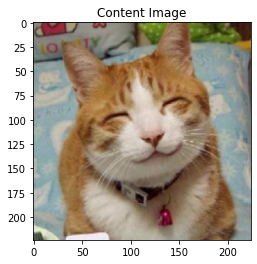

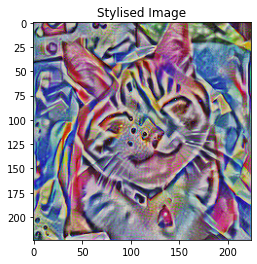

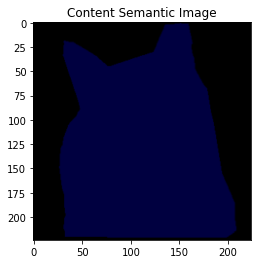

In [ ]:
# Check the shape of the stylised image
# Original Content Image
original_img = image_loader("/content/content_image/2008_006599.jpg", imsize) # Change the directory to the content image you want!!
# original_img = original_img.resize(original_img.shape[1], original_img.shape[2], original_img.shape[3])
print(original_img.shape)
# Stylised Image
stylised_content_img = stylised_img
# stylised_content_img = stylised_content_img.resize(stylised_content_img.shape[1], stylised_content_img.shape[2], stylised_content_img.shape[3])
print(stylised_content_img.shape)
# Original Content Image Label
content_img_label = image_loader("/content/label_image/2008_006599.png", imsize) # Change the directory to the image semantic edge you compute!!
# content_img_label = content_img_label.resize(content_img_label.shape[1], content_img_label.shape[2], content_img_label.shape[3])
print(content_img_label.shape)

# Show these two images
plt.figure()
original_image_PIL = imshow(original_img, title='Content Image')
plt.figure()
stylised_content_img = imshow(stylised_content_img, title='Stylised Image')
plt.figure()
content_img_label_PIL = imshow(content_img_label, title='Content Semantic Image')

Now we have three images in Tensor form. Next we want to blend the original content image with the stylised image based on the semantic segmentation result from the content image label.

number of non-background pixel:  30683


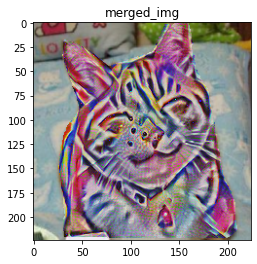

In [ ]:
# Show the RGB value of the content image label
# pix_label = content_img_label_PIL.load()
# for x in range(content_img_label_PIL.size[0]):
#   for y in range(content_img_label_PIL.size[1]):
#     r, g, b = pix_label[x, y]
#     if (r != 0) or (g != 0) or (b != 0):
#       print("r, g, b: ", pix_label[x, y])

# Save the non-background pixel locations to a list
stylised_lst = []
pix_label = content_img_label_PIL.load()
for x in range(content_img_label_PIL.size[0]):
  for y in range(content_img_label_PIL.size[1]):
    r, g, b = pix_label[x, y]
    if (r != 0) or (g != 0) or (b != 0):
      stylised_lst.append([x, y])
print("number of non-background pixel: ", len(stylised_lst))

# Change the pixel value
merged_img_PIL = original_image_PIL
merged_pix = merged_img_PIL.load()

stylised_content_img_pix = stylised_content_img.load()
for cord in stylised_lst:
  x, y = cord[0], cord[1]
  merged_pix[x, y] = stylised_content_img_pix[x, y]

# Show the merged image
plt.imshow(merged_img_PIL)
plt.title('merged_img')
plt.show()